# Py annotation visualizer
Inspired by Xenium Explorer and CellxGene to do rapid visualization of omics data

In [2]:
## import packages:
import base64, json, uuid, traceback
from typing import Any, Dict, Callable, Optional
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scanpy as sc
import squidpy as sq
import ipywidgets as widgets
from IPython.display import HTML, Javascript, display

/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text fro

In [3]:
import os
os.getcwd()

'/krummellab/data1/zachsten/personal/py_anndata_visualizer'

### Reading in the big function:

In [4]:
# PART 1: Main body:
# Buttons and main body:
def _b64(s: str) -> str:
    """Base64 encode a string."""
    return base64.b64encode(s.encode("utf-8")).decode("ascii")


def _serialize_result(result: Any) -> Dict:
    """Safely serialize callback results to JSON-compatible format."""
    if isinstance(result, dict):
        return {k: _serialize_result(v) for k, v in result.items()}
    elif isinstance(result, (list, tuple)):
        return [_serialize_result(item) for item in result]
    elif isinstance(result, np.ndarray):
        return result.tolist()
    elif isinstance(result, (np.integer, np.floating)):
        return result.item()
    elif isinstance(result, pd.Series):
        return result.tolist()
    elif isinstance(result, pd.DataFrame):
        return result.to_dict("records")
    elif hasattr(result, "toarray"):
        return result.toarray().tolist()
    elif isinstance(result, (str, int, float, bool, type(None))):
        return result
    else:
        return str(result)


def link_buttons_to_python(
    html_content: str,
    button_callbacks: Dict[str, Callable],
    callback_args: Optional[Dict[str, Any]] = None,
    height: int = 600,
    width: int = 900,
    debug: bool = False,
    max_result_size: int = 10_000_000,
    initial_data: Optional[Dict] = None,
) -> str:
    """
    Link HTML buttons to Python callbacks using widget-based communication.
    Adds a 2-panel layout:
      - Left: iframe UI (buttons/inputs)
      - Right: plot canvas (transparent) that can:
          * render embedding points: spatial/umap/pca (loaded upfront)
          * color points by continuous (GEX/obs numeric) or categorical (obs)
          * clear overlay back to neutral grey
    """
    if callback_args is None:
        callback_args = {}
    if initial_data is None:
        initial_data = {}

    iframe_id = f"iframe_{uuid.uuid4().hex}"
    output = widgets.Output()

    button_ids = list(button_callbacks.keys())
    button_ids_js = json.dumps(button_ids)
    initial_data_js = json.dumps(initial_data)

    # ----------------------------
    # Create data bridge widgets (one per button)
    # ----------------------------
    data_bridges: Dict[str, widgets.Text] = {}
    for bid in button_ids:
        bridge_name = f"_data_{iframe_id}_{bid}"
        bridge = widgets.Text(
            value="",
            description=bridge_name,
            placeholder=f"Data bridge for {bid}",
            layout=widgets.Layout(width="1px", height="1px", visibility="hidden"),
        )
        bridge.add_class(f"data-bridge-{iframe_id}")
        bridge.add_class(f"data-bridge-{bid}")
        data_bridges[bid] = bridge
        display(bridge)

    # ----------------------------
    # JS injected inside iframe:
    # - captures button clicks + input fields
    # - posts to parent
    # - receives python responses and re-dispatches as CustomEvent('pythonResponse')
    # ----------------------------
    communication_script = f"""
<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};
  const buttonIds = {button_ids_js};
  const initialData = {initial_data_js};
  let pendingRequest = null;

  function log(...args) {{ {"console.log('[iframe]', ...args);" if debug else ""} }}

  window.INITIAL_DATA = initialData;
  log("Initial data loaded:", initialData);

  buttonIds.forEach((bid) => {{
    const button = document.getElementById(bid);
    if (!button) {{
      log("Button not found:", bid);
      return;
    }}

    button.addEventListener('click', () => {{
      if (pendingRequest === bid) {{
        log("Request already pending for", bid);
        return;
      }}

      pendingRequest = bid;
      log("Button clicked:", bid);
      button.disabled = true;

      const data = {{}};

      // data-* attributes on the button
      for (let attr of button.attributes) {{
        if (attr.name.startsWith('data-')) {{
          data[attr.name.substring(5)] = attr.value;
        }}
      }}

      // inputs associated to this button via data-for="buttonId"
      const inputs = document.querySelectorAll('[data-for="' + bid + '"]');
      inputs.forEach(input => {{
        const key = input.getAttribute('data-key') || input.id || input.name;
        if (key) {{
          data[key] = input.value;
        }}
      }});

      log("Sending data:", data);

      window.parent.postMessage({{
        type: 'button_click',
        iframeId: iframeId,
        buttonId: bid,
        data: data,
        timestamp: Date.now()
      }}, '*');
    }});
  }});

  window.addEventListener('message', (event) => {{
    if (event.data && event.data.type === 'python_response') {{
      log("Received Python response:", event.data.data);

      if (pendingRequest) {{
        const button = document.getElementById(pendingRequest);
        if (button) button.disabled = false;
        pendingRequest = null;
      }}

      const customEvent = new CustomEvent('pythonResponse', {{
        detail: event.data.data
      }});
      window.dispatchEvent(customEvent);
    }}
  }});
}})();
</script>
"""

    if "</body>" in html_content.lower():
        idx = html_content.lower().rfind("</body>")
        full_html = html_content[:idx] + communication_script + html_content[idx:]
    else:
        full_html = html_content + communication_script

    payload_b64 = _b64(full_html)

    # ----------------------------
    # Precompute embedding points + sample indices (aligned everywhere)
    # ----------------------------
    adata = callback_args.get("adata", None)

    # pick base embedding to define sample_idx
    spatial = None
    if adata is not None:
        if "spatial" in adata.obsm:
            spatial = np.asarray(adata.obsm["spatial"])
        elif "X_spatial" in adata.obsm:
            spatial = np.asarray(adata.obsm["X_spatial"])

    if spatial is None or spatial.ndim != 2 or spatial.shape[1] < 2:
        sample_idx = np.array([], dtype=int)
        spatial_points = []
    else:
        n = spatial.shape[0]
        max_points = 1_00_000_000  # <-- THIS controls how many cells/points are loaded
        if n > max_points:
            sample_idx = np.random.choice(n, size=max_points, replace=False)
        else:
            sample_idx = np.arange(n, dtype=int)
        spatial_points = spatial[sample_idx, :2].tolist()

    # Optional embeddings (same sample_idx; empty if missing)
    umap_points: list = []
    pca_points: list = []
    if adata is not None and sample_idx.size > 0:
        if "X_umap" in adata.obsm:
            um = np.asarray(adata.obsm["X_umap"])
            if um.ndim == 2 and um.shape[1] >= 2 and um.shape[0] == (spatial.shape[0] if spatial is not None else um.shape[0]):
                umap_points = um[sample_idx, :2].tolist()

        if "X_pca" in adata.obsm:
            pc = np.asarray(adata.obsm["X_pca"])
            if pc.ndim == 2 and pc.shape[1] >= 2 and pc.shape[0] == (spatial.shape[0] if spatial is not None else pc.shape[0]):
                pca_points = pc[sample_idx, :2].tolist()

    embeds_js = json.dumps({
        "spatial": spatial_points,
        "umap": umap_points,
        "pca": pca_points,
    })

    # IMPORTANT: pass sample_idx into callbacks so obs/gene are subset to plotted points
    callback_args = dict(callback_args)
    callback_args["__sample_idx"] = sample_idx.tolist()  # JSON-friendly

    # ----------------------------
    # Parent container: 2 panels + plot canvas (transparent background)
    # ----------------------------
    container_html = f"""
<div style="display:flex; gap:10px; width:100%; height:{int(height)}px;">
  <!-- Left panel: controls iframe -->
  <div id="left_{iframe_id}" style="width: 420px; height:100%; flex: 0 0 420px;">
    <iframe
      id="{iframe_id}"
      style="width:100%; height:100%; border:1px solid #ccc; border-radius:6px; background:white;"
    ></iframe>
  </div>

  <!-- Right panel: plot area -->
  <div id="plot_panel_{iframe_id}"
       tabindex="0"
       style="width:{int(width)}px; height:100%; flex: 0 0 {int(width)}px; border:1px solid rgba(0,0,0,0.15); border-radius:6px;
              background: transparent; position: relative; overflow:hidden; outline:none;">
    <canvas id="plot_canvas_{iframe_id}"
            style="width:100%; height:100%; display:block; background: transparent;"></canvas>

    <!-- Hidden label (needed for state tracking but not displayed) -->
    <div id="plot_label_{iframe_id}" style="display:none;">Embedding: spatial</div>

    <!-- Camera button in top left -->
    <button id="camera_btn_{iframe_id}"
            style="position:absolute; left:10px; top:10px;
                   width:36px; height:36px;
                   border-radius:8px;
                   border:1px solid rgba(0,0,0,0.12);
                   background: rgba(255,255,255,0.9);
                   cursor:pointer;
                   display:flex;
                   align-items:center;
                   justify-content:center;
                   transition: all 0.15s ease;
                   box-shadow: 0 2px 4px rgba(0,0,0,0.08);"
            title="Download plot as PNG">
      <svg width="20" height="20" viewBox="0 0 24 24" fill="none" stroke="currentColor" stroke-width="2" stroke-linecap="round" stroke-linejoin="round">
        <path d="M23 19a2 2 0 0 1-2 2H3a2 2 0 0 1-2-2V8a2 2 0 0 1 2-2h4l2-3h6l2 3h4a2 2 0 0 1 2 2z"></path>
        <circle cx="12" cy="13" r="4"></circle>
      </svg>
    </button>
    
    <!-- Minimap in bottom left -->
    <canvas id="minimap_{iframe_id}"
            style="position:absolute; bottom:10px; left:10px;
                   width:120px; height:120px;
                   background:#000;
                   border:2px solid rgba(255,255,255,0.3);
                   border-radius:8px;
                   display:block;"></canvas>
  </div>
</div>

<style>
  #camera_btn_{iframe_id}:hover {{
    background: rgba(141,236,245,0.2);
    border-color: rgba(141,236,245,0.6);
    box-shadow: 0 4px 8px rgba(0,0,0,0.12);
  }}
</style>

<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};

  const iframe = document.getElementById({json.dumps(iframe_id)});
  const b64 = {json.dumps(payload_b64)};
  const html = decodeURIComponent(escape(atob(b64)));

  // ---- write iframe content ----
  const doc = iframe.contentWindow.document;
  doc.open();
  doc.write(html);
  doc.close();

  // ---- request queue for button bridge ----
  window["_requests_" + iframeId] = [];

  function log(...args) {{ {"console.log('[parent]', ...args);" if debug else ""} }}

  // Guard against duplicate listener on reruns for this iframe_id
  const MSG_GUARD = "_msg_listener_installed_" + iframeId;
  if (!window[MSG_GUARD]) {{
    window[MSG_GUARD] = true;
    window.addEventListener('message', (event) => {{
      if (!event.data) return;
      if (event.data.iframeId === iframeId && event.data.type === "button_click") {{
        log("Queued button click:", event.data.buttonId, "with data:", event.data.data);
        window["_requests_" + iframeId].push(event.data);
      }}
      // Listen to ui_state updates from iframe (for legend toggles, opacity, etc)
      if (event.data.type === "ui_state") {{
        log("Received ui_state update from iframe");
        const s = window["_plotState_" + iframeId];
        
        // Update obs layer
        if (s && event.data.obs) {{
          if (event.data.obs.values) {{
            // Obs data is active
            s.obs.mode = event.data.obs.mode;
            s.obs.values = event.data.obs.values;
            s.obs.colors = event.data.obs.colors;
            s.obs.categories = event.data.obs.categories;
            s.obs.enabled = event.data.obs.enabled;
            s.obs.opacity = event.data.obs.opacity || 1.0;
          }} else {{
            // No obs data - clear obs layer
            s.obs.mode = null;
            s.obs.values = null;
            s.obs.colors = null;
            s.obs.categories = null;
            s.obs.enabled = null;
          }}
        }}
        
        // Update GEX layer
        if (s && event.data.gex) {{
          if (event.data.gex.active && event.data.gex.values) {{
            // GEX is active
            s.gex.values = event.data.gex.values;
            s.gex.opacity = event.data.gex.opacity || 1.0;
          }} else {{
            // No GEX - clear GEX layer
            s.gex.values = null;
          }}
        }}
        
        // Update selection mask and outline
        if (s && event.data.selection) {{
          s.selectionIndices = event.data.selection.indices || null;
          s.selectionPath = event.data.selection.path || null;
          s.selectionTool = event.data.selection.tool || null;
        }}
        
        // Update point size
        if (s && typeof event.data.pointSize === 'number') {{
          s.pointSize = event.data.pointSize;
        }}
        
        // Update label
        if (s) {{
          const hasObs = s.obs.values != null;
          const hasGex = s.gex.values != null;
          
          if (hasGex && hasObs) {{
            s.label = "obs: " + (event.data.obs.column || "") + " + GEX: " + (event.data.gex.active || "");
          }} else if (hasGex) {{
            s.label = "GEX: " + (event.data.gex.active || "");
          }} else if (hasObs) {{
            s.label = "obs: " + (event.data.obs.column || "");
          }} else {{
            s.label = "Embedding: " + currentEmbedding;
          }}
          setLabel(s.label);
        }}
        
        draw();
      }}
      
      // Listen for selection_tool messages from iframe
      if (event.data.type === "selection_tool") {{
        const tool = event.data.tool;
        window["_selectionTool_" + iframeId] = tool;
        window["_selectionPath_" + iframeId] = [];
        window["_isDrawing_" + iframeId] = false;
        log("Selection tool changed to:", tool);
        draw(); // Redraw to clear any previous selection outline
      }}
      
      // Listen for save_obs_column message from iframe
      if (event.data.type === "save_obs_column" && event.data.iframeId === iframeId) {{
        log("Saving obs column:", event.data.columnName);
        // Queue this as a special request to be handled by Python
        window["_requests_" + iframeId].push({{
          buttonId: "__save_obs_column__",
          data: {{
            columnName: event.data.columnName,
            columnData: event.data.columnData
          }},
          type: "button_click",
          iframeId: iframeId
        }});
      }}
    }});
  }}

  window["sendToIframe_" + iframeId] = function(data) {{
    const iframe2 = document.getElementById(iframeId);
    if (iframe2 && iframe2.contentWindow) {{
      iframe2.contentWindow.postMessage({{
        type: "python_response",
        data: data
      }}, "*");
    }}
  }};

  // ----------------------------
  // Embeddings (preloaded)
  // ----------------------------
  const EMBEDS = {embeds_js};
  let currentEmbedding = "spatial";
  let points = (EMBEDS[currentEmbedding] || []);

  // ----------------------------
  // Navigation state (zoom, pan, rotation)
  // ----------------------------
  let zoom = 1.0;
  let panX = 0;
  let panY = 0;
  let rotation = 0;
  let isDragging = false;
  let lastMouseX = 0;
  let lastMouseY = 0;
  let rotationMode = false;
  let lastRotationKeyPress = 0;
  
  // ----------------------------
  // Animation state
  // ----------------------------
  let isAnimating = false;
  let animationStartTime = 0;
  let animationDuration = 1000; // 1 second for embedding transitions
  let startPoints = null;
  let endPoints = null;
  
  // Color animation
  let colorAnimating = false;
  let colorAnimStart = 0;
  const COLOR_ANIM_MS = 500; // 0.5 seconds
  let oldColors = null;
  let newColors = null;
  
  // Helper function for smooth interpolation
  function lerp(a, b, t) {{
    return a + (b - a) * t;
  }}
  
  // Easing function (ease-in-out)
  function easeInOutQuad(t) {{
    return t < 0.5 ? 2 * t * t : 1 - Math.pow(-2 * t + 2, 2) / 2;
  }}

  // ----------------------------
  // Plot state (supports layered rendering: obs + GEX overlay)
  // ----------------------------
  window["_plotState_" + iframeId] = {{
    // Obs layer (base)
    obs: {{
      mode: null,           // "categorical" | "continuous" | null
      values: null,         // per-point values
      colors: null,         // categorical palette
      categories: null,
      enabled: null,        // boolean array for categorical toggles
      opacity: 1.0
    }},
    // GEX layer (overlay)
    gex: {{
      values: null,         // per-point continuous values
      opacity: 1.0
    }},
    label: "Embedding: spatial",
    pointSize: 1.1,
    selectionIndices: null  // array of selected point indices (acts as mask)
  }};

  function setLabel(text) {{
    const lab = document.getElementById("plot_label_" + iframeId);
    if (lab) lab.textContent = text;
  }}

  // Camera button - download canvas as PNG with custom filename
  const cameraBtn = document.getElementById("camera_btn_" + iframeId);
  if (cameraBtn) {{
    cameraBtn.addEventListener("click", () => {{
      // Prompt for filename
      const defaultName = "spatial_plot_" + new Date().toISOString().slice(0,10);
      const filename = prompt("Enter filename for PNG (without extension):", defaultName);
      
      // If user cancelled or entered empty string, don't download
      if (!filename || filename.trim() === "") {{
        return;
      }}
      
      // Download with user's filename
      const link = document.createElement("a");
      link.download = filename.trim() + ".png";
      link.href = canvas.toDataURL("image/png");
      link.click();
    }});
  }}

  // ----------------------------
  // Plot updater: receives Python callback payloads
  // ----------------------------
  window["updatePlot_" + iframeId] = function(payload) {{
    if (!payload || !payload.type) return;

    // Switch embedding (UMAP/PCA/Spatial) - PRESERVE COLOR STATE WITH ANIMATION
    if (payload.type === "set_embedding") {{
      const name = (payload.embedding || "spatial");
      const newPoints = (EMBEDS[name] || []);
      
      // Don't animate if already on this embedding
      if (currentEmbedding === name) return;
      
      // Start animation
      startPoints = points.slice(); // Copy current points
      endPoints = newPoints;
      currentEmbedding = name;
      isAnimating = true;
      animationStartTime = Date.now();
      
      // Reset navigation on embedding switch
      zoom = 1.0;
      panX = 0;
      panY = 0;
      rotation = 0;
      
      function animateEmbedding() {{
        const elapsed = Date.now() - animationStartTime;
        const progress = Math.min(elapsed / animationDuration, 1);
        const eased = easeInOutQuad(progress);
        
        // Interpolate all points
        points = [];
        for (let i = 0; i < startPoints.length; i++) {{
          const [sx, sy] = startPoints[i];
          const [ex, ey] = endPoints[i];
          points.push([
            lerp(sx, ex, eased),
            lerp(sy, ey, eased)
          ]);
        }}
        
        draw();
        
        if (progress < 1) {{
          requestAnimationFrame(animateEmbedding);
        }} else {{
          points = endPoints;
          isAnimating = false;
          draw();
        }}
      }}
      
      animateEmbedding();

      // Update label
      const s = window["_plotState_" + iframeId];
      if (s) {{
        if (s.mode === "none") {{
          s.label = "Embedding: " + name;
        }}
      }}
      setLabel(s ? s.label : "Embedding: " + name);
      return;
    }}

    // Clear overlay (back to neutral grey)
    if (payload.type === "clear_plot") {{
      const s = window["_plotState_" + iframeId];
      if (s) {{
        // Clear obs layer
        s.obs.mode = null;
        s.obs.values = null;
        s.obs.colors = null;
        s.obs.categories = null;
        s.obs.enabled = null;
        // Clear GEX layer
        s.gex.values = null;
        s.label = "Embedding: " + currentEmbedding;
      }}
      setLabel("Embedding: " + currentEmbedding);
      draw();
      return;
    }}

    // GEX continuous - store in GEX layer
    if (payload.type === "gex_values") {{
      const s = window["_plotState_" + iframeId];
      if (s) {{
        s.gex.values = payload.values || null;
        s.label = "GEX: " + (payload.gene || "");
      }}
      setLabel("GEX: " + (payload.gene || ""));
      draw();
      return;
    }}

    // obs values (categorical or continuous) - store in obs layer
    if (payload.type === "obs_values") {{
      const s = window["_plotState_" + iframeId];
      if (s) {{
        if (payload.mode === "categorical") {{
          s.obs.mode = "categorical";
          s.obs.values = payload.values || null;
          s.obs.colors = payload.colors || null;
          s.obs.categories = payload.categories || null;
          // Initialize enabled array - all true by default
          if (s.obs.categories) {{
            s.obs.enabled = s.obs.categories.map(() => true);
          }}
        }} else {{
          s.obs.mode = "continuous";
          s.obs.values = payload.values || null;
          s.obs.colors = null;
          s.obs.categories = null;
          s.obs.enabled = null;
        }}
        s.label = "obs: " + (payload.column || "");
      }}
      setLabel("obs: " + (payload.column || ""));
      draw();
      return;
    }}
  }};

  // ----------------------------
  // Plotting
  // ----------------------------
  const canvas = document.getElementById("plot_canvas_" + iframeId);
  const panel = document.getElementById("plot_panel_" + iframeId);
  const ctx = canvas.getContext("2d");
  
  const minimap = document.getElementById("minimap_" + iframeId);
  const minimapCtx = minimap.getContext("2d");

  function clamp01(x) {{ return Math.max(0, Math.min(1, x)); }}

  // Minimal viridis approximation via stops
  const VIRIDIS = [
    [0.0,  [68, 1, 84]],
    [0.13, [71, 44, 122]],
    [0.25, [59, 81, 139]],
    [0.38, [44, 113, 142]],
    [0.50, [33, 144, 141]],
    [0.63, [39, 173, 129]],
    [0.75, [92, 200, 99]],
    [0.88, [170, 220, 50]],
    [1.0,  [253, 231, 37]]
  ];

  function viridis(t) {{
    t = clamp01(t);
    for (let i = 0; i < VIRIDIS.length - 1; i++) {{
      const a = VIRIDIS[i], b = VIRIDIS[i + 1];
      if (t >= a[0] && t <= b[0]) {{
        const u = (t - a[0]) / (b[0] - a[0] || 1);
        const r = Math.round(a[1][0] + u*(b[1][0]-a[1][0]));
        const g = Math.round(a[1][1] + u*(b[1][1]-a[1][1]));
        const bl = Math.round(a[1][2] + u*(b[1][2]-a[1][2]));
        return `rgb(${{r}},${{g}},${{bl}})`;
      }}
    }}
    const c = VIRIDIS[VIRIDIS.length - 1][1];
    return `rgb(${{c[0]}},${{c[1]}},${{c[2]}})`;
  }}

  function fallbackCatColor(k) {{
    const h = (k * 137.508) % 360;
    return `hsl(${{h}}, 55%, 55%)`;
  }}

  function resizeCanvas() {{
    const rect = panel.getBoundingClientRect();
    canvas.width = Math.max(1, Math.floor(rect.width * window.devicePixelRatio));
    canvas.height = Math.max(1, Math.floor(rect.height * window.devicePixelRatio));
    ctx.setTransform(1, 0, 0, 1, 0, 0);
    ctx.scale(window.devicePixelRatio, window.devicePixelRatio);
    draw();
  }}

  function draw() {{
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;

    ctx.clearRect(0, 0, W, H);

    if (!points || points.length === 0) {{
      ctx.font = "13px ui-monospace, Menlo, Monaco, monospace";
      ctx.fillStyle = "rgba(0,0,0,0.6)";
      ctx.fillText("Embedding not available (missing in adata.obsm).", 12, 40);
      return;
    }}

    // bounds
    let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0], y = points[i][1];
      if (x < minX) minX = x;
      if (x > maxX) maxX = x;
      if (y < minY) minY = y;
      if (y > maxY) maxY = y;
    }}

    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    
    // Apply zoom
    const scale = baseScale * zoom;

    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Apply rotation transform
    ctx.save();
    ctx.translate(W / 2, H / 2);
    ctx.rotate(rotation);
    ctx.translate(-W / 2, -H / 2);

    const state = window["_plotState_" + iframeId] || {{ obs: {{}}, gex: {{}} }};

    // Calculate GEX continuous range if needed
    let gexMin = 0, gexMax = 1;
    if (state.gex && state.gex.values && state.gex.values.length === points.length) {{
      gexMin = Infinity; gexMax = -Infinity;
      for (let i = 0; i < state.gex.values.length; i++) {{
        const v = state.gex.values[i];
        if (v == null || Number.isNaN(v)) continue;
        if (v < gexMin) gexMin = v;
        if (v > gexMax) gexMax = v;
      }}
      if (!isFinite(gexMin) || !isFinite(gexMax) || gexMin === gexMax) {{ gexMin = 0; gexMax = 1; }}
    }}

    // Calculate obs continuous range if needed
    let obsMin = 0, obsMax = 1;
    if (state.obs && state.obs.mode === "continuous" && state.obs.values && state.obs.values.length === points.length) {{
      obsMin = Infinity; obsMax = -Infinity;
      for (let i = 0; i < state.obs.values.length; i++) {{
        const v = state.obs.values[i];
        if (v == null || Number.isNaN(v)) continue;
        if (v < obsMin) obsMin = v;
        if (v > obsMax) obsMax = v;
      }}
      if (!isFinite(obsMin) || !isFinite(obsMax) || obsMin === obsMax) {{ obsMin = 0; obsMax = 1; }}
    }}

    const r = state.pointSize || 1.1;

    // Layered rendering with categorical masking
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0];
      const y = points[i][1];
      const px = offX + (x - minX) * scale;
      const py = offY + (y - minY) * scale;

      // MASKING: Check if this point passes categorical mask
      let passesMask = true;
      
      // Categorical mask (from obs toggles)
      if (state.obs && state.obs.mode === "categorical" && state.obs.values && state.obs.values.length === points.length) {{
        const k = state.obs.values[i] | 0;
        const isEnabled = !state.obs.enabled || state.obs.enabled[k] !== false;
        passesMask = passesMask && isEnabled;
      }}
      
      // If point doesn't pass categorical mask, skip it entirely
      if (!passesMask) {{
        continue;
      }}
      
      // SELECTION OPACITY: Check if this point is in active selection
      let selectionOpacity = 1.0;
      if (state.selectionIndices && state.selectionIndices.length > 0) {{
        // If there's an active selection, selected points = 1.0, others = 0.2
        selectionOpacity = state.selectionIndices.includes(i) ? 1.0 : 0.2;
      }}
      
      // Determine what to draw for this point
      let hasObsColor = false;
      let hasGexColor = false;
      
      // Check obs layer
      if (state.obs && state.obs.mode === "categorical" && state.obs.values && state.obs.values.length === points.length) {{
        hasObsColor = true;
      }} else if (state.obs && state.obs.mode === "continuous" && state.obs.values && state.obs.values.length === points.length) {{
        hasObsColor = true;
      }}
      
      // Check GEX layer
      if (state.gex && state.gex.values && state.gex.values.length === points.length) {{
        hasGexColor = true;
      }}
      
      // Skip point entirely if no active layers (no obs, no GEX)
      if (!hasObsColor && !hasGexColor) {{
        continue;
      }}

      // Draw obs base layer first (if exists)
      if (hasObsColor) {{
        if (state.obs.mode === "categorical") {{
          const k = state.obs.values[i] | 0;
          const pal = state.obs.colors;
          ctx.globalAlpha = (state.obs.opacity || 1.0) * selectionOpacity;
          ctx.fillStyle = (pal && pal[k]) ? pal[k] : fallbackCatColor(k);
        }} else if (state.obs.mode === "continuous") {{
          const v = state.obs.values[i];
          const t = (v - obsMin) / (obsMax - obsMin || 1);
          ctx.globalAlpha = (state.obs.opacity || 1.0) * selectionOpacity;
          ctx.fillStyle = viridis(t);
        }}
        
        ctx.beginPath();
        ctx.arc(px, py, r, 0, Math.PI * 2);
        ctx.fill();
      }}

      // Draw GEX overlay on top (if exists)
      if (hasGexColor) {{
        const v = state.gex.values[i];
        const t = (v - gexMin) / (gexMax - gexMin || 1);
        ctx.globalAlpha = (state.gex.opacity || 1.0) * selectionOpacity;
        ctx.fillStyle = viridis(t);
        
        ctx.beginPath();
        ctx.arc(px, py, r, 0, Math.PI * 2);
        ctx.fill();
      }}
    }}

    ctx.globalAlpha = 1.0;
    
    // Restore rotation transform
    ctx.restore();
    
    // NOTE: We don't draw stored selection outlines because they're stored in
    // screen coordinates and become incorrect after zoom/pan/rotate.
    // The opacity dimming (selected=1.0, unselected=0.2) is sufficient visual feedback.
    
    // Draw minimap
    drawMinimap();
  }}
  
  // ----------------------------
  // Minimap drawing
  // ----------------------------
  function drawMinimap() {{
    const mmW = minimap.width;
    const mmH = minimap.height;
    
    minimapCtx.fillStyle = "#000";
    minimapCtx.fillRect(0, 0, mmW, mmH);
    
    // Calculate bounds for current points
    if (!points || points.length === 0) return;
    
    let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0], y = points[i][1];
      if (x < minX) minX = x;
      if (x > maxX) maxX = x;
      if (y < minY) minY = y;
      if (y > maxY) maxY = y;
    }}
    
    const pad = 5;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const scale = Math.min((mmW - 2*pad) / spanX, (mmH - 2*pad) / spanY);
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (mmW - usedW) / 2;
    const offY = (mmH - usedH) / 2;
    
    // Draw all points as small dots
    minimapCtx.fillStyle = "rgba(100, 100, 100, 0.5)";
    for (let i = 0; i < points.length; i++) {{
      const [x, y] = points[i];
      const px = offX + (x - minX) * scale;
      const py = offY + (y - minY) * scale;
      minimapCtx.fillRect(px - 0.5, py - 0.5, 1, 1);
    }}
    
    // Draw viewport rectangle
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    const baseScale = Math.min((W - 24) / spanX, (H - 24) / spanY);
    const viewScale = baseScale * zoom;
    const viewW = spanX * viewScale;
    const viewH = spanY * viewScale;
    const viewOffX = (W - viewW) / 2 + panX;
    const viewOffY = (H - viewH) / 2 + panY;
    
    // Map viewport to minimap coordinates
    const vpMinX = -viewOffX / viewScale * scale + offX;
    const vpMinY = -viewOffY / viewScale * scale + offY;
    const vpMaxX = (W - viewOffX) / viewScale * scale + offX;
    const vpMaxY = (H - viewOffY) / viewScale * scale + offY;
    
    minimapCtx.strokeStyle = "rgba(141, 236, 245, 0.8)";
    minimapCtx.lineWidth = 1;
    minimapCtx.strokeRect(vpMinX, vpMinY, vpMaxX - vpMinX, vpMaxY - vpMinY);
  }}

  resizeCanvas();
  window.addEventListener("resize", resizeCanvas);

  // ----------------------------
  // Pan/Zoom/Rotation controls
  // ----------------------------
  
  // Wheel zoom (slowed to 0.5x)
  canvas.addEventListener("wheel", (e) => {{
    e.preventDefault();
    const rect = canvas.getBoundingClientRect();
    const mouseX = e.clientX - rect.left;
    const mouseY = e.clientY - rect.top;
    
    const delta = e.deltaY * 0.0005;  // Was 0.001, now 0.0005 for slower zoom
    const zoomFactor = delta > 0 ? 0.975 : 1.025;  // Reduced from 0.95/1.05
    const oldZoom = zoom;
    zoom *= zoomFactor;
    zoom = Math.max(0.1, Math.min(zoom, 20));
    
    const zoomChange = zoom / oldZoom;
    panX = mouseX - (mouseX - panX) * zoomChange;
    panY = mouseY - (mouseY - panY) * zoomChange;
    
    draw();
  }});
  
  // Double-click to reset view
  canvas.addEventListener("dblclick", () => {{
    zoom = 1.0;
    panX = 0;
    panY = 0;
    rotation = 0;
    rotationMode = false;
    draw();
  }});
  
  // Auto-focus panel on mouse enter to capture keyboard events
  panel.addEventListener("mouseenter", () => {{
    panel.focus();
  }});
  
  // Keyboard controls - only work when panel has focus
  panel.addEventListener("keydown", (e) => {{
    // Arrow keys for size (when not in input)
    if (e.target.tagName === 'INPUT' && e.target.type === 'text') return;
    
    if (e.key === "ArrowLeft" || e.key === "ArrowRight") {{
      e.preventDefault();
      e.stopPropagation();
      const state = window["_plotState_" + iframeId];
      if (!state) return;
      
      const step = 0.1;
      const min = 0.5;
      const max = 8;
      
      if (e.key === "ArrowLeft") {{
        state.pointSize = Math.max(min, state.pointSize - step);
      }} else {{
        state.pointSize = Math.min(max, state.pointSize + step);
      }}
      
      draw();
    }}
    
    // R key for rotation
    if (e.key === "r" || e.key === "R") {{
      e.preventDefault();
      e.stopPropagation();
      const now = Date.now();
      if (now - lastRotationKeyPress < 500) {{
        // Double-tap: reset rotation
        rotation = 0;
        rotationMode = false;
      }} else {{
        // Single tap: toggle rotation mode
        rotationMode = !rotationMode;
        canvas.style.cursor = rotationMode ? "crosshair" : "default";
      }}
      lastRotationKeyPress = now;
      draw();
    }}
  }});
  
  // Rotation with mouse when in rotation mode
  canvas.addEventListener("mousemove", (e) => {{
    if (rotationMode && !isDragging && !window["_isDrawing_" + iframeId]) {{
      const rect = canvas.getBoundingClientRect();
      const centerX = rect.width / 2;
      const centerY = rect.height / 2;
      const angle = Math.atan2(e.clientY - rect.top - centerY, e.clientX - rect.left - centerX);
      rotation = angle;
      draw();
      return;
    }}
  }});

  // ----------------------------
  // Selection drawing AND panning
  // ----------------------------
  canvas.addEventListener("mousedown", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    const rect = canvas.getBoundingClientRect();
    const x = e.clientX - rect.left;
    const y = e.clientY - rect.top;
    
    // Exit rotation mode on click (locks rotation in place)
    if (rotationMode) {{
      rotationMode = false;
      canvas.style.cursor = "default";
      return;
    }}
    
    if (tool) {{
      // Selection drawing mode
      window["_isDrawing_" + iframeId] = true;
      window["_selectionPath_" + iframeId] = [[x, y]];
      
      if (tool === "rectangle" || tool === "circle") {{
        window["_selectionStart_" + iframeId] = [x, y];
      }}
    }} else if (!rotationMode) {{
      // Panning mode
      isDragging = true;
      lastMouseX = e.clientX;
      lastMouseY = e.clientY;
      canvas.style.cursor = "grabbing";
    }}
  }});
  
  canvas.addEventListener("mousemove", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    const rect = canvas.getBoundingClientRect();
    const x = e.clientX - rect.left;
    const y = e.clientY - rect.top;
    
    if (tool && window["_isDrawing_" + iframeId]) {{
      // Selection drawing
      if (tool === "lasso" || tool === "polygon") {{
        window["_selectionPath_" + iframeId].push([x, y]);
      }} else if (tool === "rectangle" || tool === "circle") {{
        window["_selectionPath_" + iframeId] = [window["_selectionStart_" + iframeId], [x, y]];
      }}
      drawSelectionOutline();
    }} else if (isDragging) {{
      // Panning - rotation-aware
      const dx = e.clientX - lastMouseX;
      const dy = e.clientY - lastMouseY;
      
      // Rotate the pan delta by the inverse of current rotation
      const cos = Math.cos(-rotation);
      const sin = Math.sin(-rotation);
      const rotatedDx = dx * cos - dy * sin;
      const rotatedDy = dx * sin + dy * cos;
      
      panX += rotatedDx;
      panY += rotatedDy;
      lastMouseX = e.clientX;
      lastMouseY = e.clientY;
      draw();
    }}
  }});
  
  canvas.addEventListener("mouseup", () => {{
    const tool = window["_selectionTool_" + iframeId];
    
    if (tool && window["_isDrawing_" + iframeId]) {{
      window["_isDrawing_" + iframeId] = false;
      
      // For polygon, don't complete on mouseup
      if (tool === "polygon") {{
        return;
      }}
      
      completeSelection();
    }}
    
    // End panning
    if (isDragging) {{
      isDragging = false;
      canvas.style.cursor = "default";
    }}
  }});
  
  canvas.addEventListener("mouseleave", () => {{
    if (isDragging) {{
      isDragging = false;
      canvas.style.cursor = "default";
    }}
  }});
  
  // Polygon: click adds point, double-click completes
  canvas.addEventListener("click", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    if (tool !== "polygon" || !window["_isDrawing_" + iframeId]) return;
    
    // Point already added in mousemove
  }});
  
  canvas.addEventListener("dblclick", (e) => {{
    const tool = window["_selectionTool_" + iframeId];
    if (tool !== "polygon") return;
    
    e.preventDefault();
    completeSelection();
  }});
  
  // Draw white outline of current selection
  function drawSelectionOutline() {{
    draw(); // Redraw base plot
    
    const path = window["_selectionPath_" + iframeId];
    const tool = window["_selectionTool_" + iframeId];
    if (!path || path.length === 0) return;
    
    const rect = panel.getBoundingClientRect();
    ctx.save();
    ctx.strokeStyle = "rgba(255, 255, 255, 0.9)";
    ctx.lineWidth = 2;
    ctx.setLineDash([5, 5]);
    
    if (tool === "lasso" && path.length > 1) {{
      ctx.beginPath();
      ctx.moveTo(path[0][0], path[0][1]);
      for (let i = 1; i < path.length; i++) {{
        ctx.lineTo(path[i][0], path[i][1]);
      }}
      ctx.stroke();
    }} else if (tool === "polygon" && path.length > 0) {{
      ctx.beginPath();
      ctx.moveTo(path[0][0], path[0][1]);
      for (let i = 1; i < path.length; i++) {{
        ctx.lineTo(path[i][0], path[i][1]);
      }}
      if (path.length > 2) {{
        ctx.closePath();
      }}
      ctx.stroke();
    }} else if (tool === "rectangle" && path.length === 2) {{
      const [x1, y1] = path[0];
      const [x2, y2] = path[1];
      ctx.strokeRect(x1, y1, x2 - x1, y2 - y1);
    }} else if (tool === "circle" && path.length === 2) {{
      const [x1, y1] = path[0];
      const [x2, y2] = path[1];
      const radius = Math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2);
      ctx.beginPath();
      ctx.arc(x1, y1, radius, 0, Math.PI * 2);
      ctx.stroke();
    }}
    
    ctx.restore();
  }}
  
  // Complete selection and detect points inside
  function completeSelection() {{
    const path = window["_selectionPath_" + iframeId];
    const tool = window["_selectionTool_" + iframeId];
    if (!path || path.length === 0) return;
    
    // Get current plot state to check categorical mask
    const state = window["_plotState_" + iframeId] || {{ obs: {{}} }};
    
    // Convert selection path from canvas coords to data coords
    const selectedIndices = [];
    const rect = panel.getBoundingClientRect();
    const W = rect.width;
    const H = rect.height;
    
    // Calculate bounds for current embedding
    let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;
    for (let i = 0; i < points.length; i++) {{
      const x = points[i][0], y = points[i][1];
      if (x < minX) minX = x;
      if (x > maxX) maxX = x;
      if (y < minY) minY = y;
      if (y > maxY) maxY = y;
    }}
    
    const pad = 12;
    const spanX = (maxX - minX) || 1;
    const spanY = (maxY - minY) || 1;
    const baseScale = Math.min((W - 2*pad) / spanX, (H - 2*pad) / spanY);
    
    // Apply zoom, pan, rotation (same as draw function)
    const scale = baseScale * zoom;
    const usedW = spanX * scale;
    const usedH = spanY * scale;
    const offX = (W - usedW) / 2 + panX;
    const offY = (H - usedH) / 2 + panY;
    
    // Check each point
    for (let i = 0; i < points.length; i++) {{
      // IMPORTANT: Only select from visible (unmasked) points
      let passesMask = true;
      if (state.obs && state.obs.mode === "categorical" && state.obs.values && state.obs.values.length === points.length) {{
        const k = state.obs.values[i] | 0;
        const isEnabled = !state.obs.enabled || state.obs.enabled[k] !== false;
        passesMask = isEnabled;
      }}
      
      // Skip masked points
      if (!passesMask) continue;
      
      const [x, y] = points[i];
      let px = offX + (x - minX) * scale;
      let py = offY + (y - minY) * scale;
      
      // Apply rotation transform to point (same as draw function)
      // Rotate around canvas center
      const centerX = W / 2;
      const centerY = H / 2;
      const dx = px - centerX;
      const dy = py - centerY;
      const cos = Math.cos(rotation);
      const sin = Math.sin(rotation);
      px = centerX + (dx * cos - dy * sin);
      py = centerY + (dx * sin + dy * cos);
      
      let inside = false;
      
      if (tool === "lasso" || tool === "polygon") {{
        inside = pointInPolygon(px, py, path);
      }} else if (tool === "rectangle") {{
        const [x1, y1] = path[0];
        const [x2, y2] = path[1];
        const minRX = Math.min(x1, x2), maxRX = Math.max(x1, x2);
        const minRY = Math.min(y1, y2), maxRY = Math.max(y1, y2);
        inside = px >= minRX && px <= maxRX && py >= minRY && py <= maxRY;
      }} else if (tool === "circle") {{
        const [cx, cy] = path[0];
        const [x2, y2] = path[1];
        const radius = Math.sqrt((x2 - cx) ** 2 + (y2 - cy) ** 2);
        const dist = Math.sqrt((px - cx) ** 2 + (py - cy) ** 2);
        inside = dist <= radius;
      }}
      
      if (inside) {{
        selectedIndices.push(i);
      }}
    }}
    
    // Send selection to iframe with path for dragging
    iframe.contentWindow.postMessage({{
      type: "selection_completed",
      indices: selectedIndices,
      path: path,
      tool: tool
    }}, "*");
    
    // Clear drawing state
    window["_selectionPath_" + iframeId] = [];
    window["_isDrawing_" + iframeId] = false;
    draw();
  }}
  
  // Point in polygon test (ray casting)
  function pointInPolygon(x, y, polygon) {{
    let inside = false;
    for (let i = 0, j = polygon.length - 1; i < polygon.length; j = i++) {{
      const xi = polygon[i][0], yi = polygon[i][1];
      const xj = polygon[j][0], yj = polygon[j][1];
      
      const intersect = ((yi > y) !== (yj > y))
        && (x < (xj - xi) * (y - yi) / (yj - yi) + xi);
      if (intersect) inside = !inside;
    }}
    return inside;
  }}

}})();
</script>
"""
    display(HTML(container_html))

    # ----------------------------
    # Poll buttons: one hidden ipywidgets.Button per iframe button id
    # ----------------------------
    for bid in button_ids:
        label = f"_poll_{iframe_id}__{bid}"
        poll_btn = widgets.Button(
            description=label,
            tooltip=label,
            layout=widgets.Layout(width="1px", height="1px", visibility="hidden"),
        )

        def make_handler(button_id: str):
            def handler(_b):
                try:
                    bridge_value = data_bridges[button_id].value
                    request_data: Dict[str, Any] = {}

                    if bridge_value:
                        try:
                            request_data = json.loads(bridge_value)
                        except json.JSONDecodeError as e:
                            if debug:
                                with output:
                                    print(f"[Python] JSON decode error: {e}, value: {bridge_value}")

                    if debug:
                        with output:
                            print(f"[Python] Handling {button_id!r}")
                            print(f"[Python] Request data: {request_data}")

                    cb = button_callbacks[button_id]
                    result = cb(request_data, **callback_args)

                    serialized = _serialize_result(result)
                    json_str = json.dumps(serialized)
                    size = len(json_str.encode("utf-8"))
                    if size > max_result_size:
                        serialized = {"type": "error", "message": f"Result too large: {size:,} bytes"}

                    with output:
                        js_code = f"""
                        (function() {{
                          const iframeId = {json.dumps(iframe_id)};
                          const sendFn = window["sendToIframe_" + iframeId];
                          const updFn  = window["updatePlot_" + iframeId];
                          if (sendFn) sendFn({json.dumps(serialized)});
                          if (updFn)  updFn({json.dumps(serialized)});
                        }})();
                        """
                        display(Javascript(js_code))

                    data_bridges[button_id].value = ""

                except Exception as e:
                    if debug:
                        with output:
                            print(f"[Python] Error in {button_id}:")
                            traceback.print_exc()

                    error_result = {
                        "type": "error",
                        "message": str(e),
                        "traceback": traceback.format_exc() if debug else None,
                    }

                    with output:
                        js_code = f"""
                        (function() {{
                          const iframeId = {json.dumps(iframe_id)};
                          const sendFn = window["sendToIframe_" + iframeId];
                          const updFn  = window["updatePlot_" + iframeId];
                          if (sendFn) sendFn({json.dumps(error_result)});
                          if (updFn)  updFn({json.dumps(error_result)});
                        }})();
                        """
                        display(Javascript(js_code))

            return handler

        poll_btn.on_click(make_handler(bid))
        display(poll_btn)

    # ----------------------------
    # Dispatcher: moves queued iframe clicks into the correct hidden widget bridge + triggers poll button
    # ----------------------------
    dispatch_script = f"""
<script>
(function() {{
  const iframeId = {json.dumps(iframe_id)};
  let busy = false;

  function findAndClick(label) {{
    const btns = Array.from(document.querySelectorAll("button"));
    for (const b of btns) {{
      const txt = (b.textContent || "");
      const title = (b.getAttribute("title") || "");
      const aria = (b.getAttribute("aria-label") || "");
      if (txt.includes(label) || title.includes(label) || aria.includes(label)) {{
        b.click();
        return true;
      }}
    }}
    return false;
  }}

  function fireWidgetEvents(inputEl) {{
    inputEl.dispatchEvent(new Event('input', {{ bubbles: true }}));
    inputEl.dispatchEvent(new Event('change', {{ bubbles: true }}));
  }}

  function findAndSetInput(description, value) {{
    const parts = description.split('_');
    const buttonId = parts[parts.length - 1];
    const iframeId2 = parts.slice(2, parts.length - 1).join('_'); // iframe_<hex>

    // Strategy 1: scope to (iframeId, buttonId) to avoid stale widgets
    const scopedSelector = '.data-bridge-' + iframeId2 + '.data-bridge-' + buttonId + ' input';
    const scoped = document.querySelector(scopedSelector);
    if (scoped) {{
      scoped.value = value;
      fireWidgetEvents(scoped);
      return true;
    }}

    // Strategy 2: match by widget label text containing the full description
    const allContainers = Array.from(document.querySelectorAll('.widget-text, .jupyter-widgets'));
    for (const container of allContainers) {{
      const label = container.querySelector('.widget-label');
      if (label && label.textContent && label.textContent.includes(description)) {{
        const input = container.querySelector('input');
        if (input) {{
          input.value = value;
          fireWidgetEvents(input);
          return true;
        }}
      }}
    }}
    return false;
  }}

  function dispatch() {{
    if (busy) return;

    const q = window["_requests_" + iframeId] || [];
    if (q.length === 0) return;

    busy = true;
    const req = q.shift();

    const pollLabel = "_poll_" + iframeId + "__" + req.buttonId;
    const dataLabel = "_data_" + iframeId + "_" + req.buttonId;

    findAndSetInput(dataLabel, JSON.stringify(req.data));

    setTimeout(() => {{
      findAndClick(pollLabel);
      setTimeout(() => {{ busy = false; }}, 100);
    }}, 150);
  }}

  setInterval(dispatch, 150);
}})();
</script>
"""
    display(HTML(dispatch_script))

    output.layout.visibility = "hidden"
    output.layout.height = "0px"
    display(output)

    return iframe_id

# PART 2! BASE HTML:
# html_template 2:
html_template = r"""
<!doctype html>
<html>
<head>
  <meta charset="utf-8"/>
  <style>
    :root{
      --accent: rgba(141,236,245,.9);
      --accentSolid: rgba(141,236,245,1);
      --accentRGB: rgb(141,236,245);
    }

    html, body {
      height:100%;
      margin:0;
      padding:0;
      background: transparent;
      font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif;
    }

    /* Panel styling (copied/trimmed from _spatial_scatter.py) */
    .panel{
      width:100%;
      height:100%;
      overflow:auto;
      border:1px solid rgba(0,0,0,.15);
      border-radius:10px;
      padding:16px;
      background:rgba(255,255,255,.98);
      box-sizing:border-box;
    }

    .control-group{ margin-bottom:20px; }
    .control-label{
      font-size:13px;
      font-weight:700;
      color:#444;
      margin-bottom:8px;
      display:block;
    }

    .embedding-selector{
      display:inline-flex;
      align-items:center;
      gap:0;
      font-size:13px;
      background:rgba(0,0,0,.05);
      border-radius:20px;
      padding:4px;
    }
    .embedding-btn{
      background:none;
      border:none;
      color:#888;
      cursor:pointer;
      padding:6px 16px;
      transition:all .2s;
      font-size:13px;
      font-weight:600;
      border-radius:16px;
    }
    .embedding-btn:hover{ color:#555; }
    .embedding-btn.active{
      background:var(--accent);
      color:#000;
      box-shadow:0 2px 8px rgba(0,0,0,.2);
    }
    .embedding-btn:disabled{ opacity:.3; cursor:not-allowed; }
    .separator{ color:#ccc; padding:0 4px; }

    input[type="text"]{
      width:100%;
      padding:8px 12px;
      border:1px solid rgba(0,0,0,.2);
      border-radius:8px;
      font-size:13px;
      background:white;
      box-sizing:border-box;
      font-family: ui-monospace, Menlo, Monaco, monospace;
    }
    input[type="text"]:focus{
      outline:none;
      border-color:var(--accent);
    }

    .btn-row{ display:flex; gap:8px; margin-top:8px; }
    .btn-primary{
      flex:1;
      padding:8px 16px;
      border:none;
      background:var(--accent);
      color:#000;
      border-radius:8px;
      cursor:pointer;
      font-size:13px;
      font-weight:800;
      transition:all .2s;
    }
    .btn-primary:hover{
      background:var(--accentSolid);
      box-shadow:0 2px 8px rgba(0,0,0,.2);
    }
    .btn-secondary{
      flex:1;
      padding:8px 16px;
      border:1px solid rgba(0,0,0,.25);
      background:rgba(255,255,255,.7);
      color:#222;
      border-radius:8px;
      cursor:pointer;
      font-size:13px;
      font-weight:800;
      transition:all .2s;
    }
    .btn-secondary:hover{
      background:rgba(255,255,255,.9);
      box-shadow:0 2px 8px rgba(0,0,0,.12);
    }

    .opacity-row{ display:flex; align-items:center; gap:10px; }
    .opacity-val{
      min-width:44px;
      text-align:right;
      font-size:12px;
      color:#666;
      font-variant-numeric:tabular-nums;
      font-family: ui-monospace, Menlo, Monaco, monospace;
    }

    /* Slider styling (filled left only) */
    input[type="range"]{
      width:100%;
      appearance:none;
      -webkit-appearance:none;
      background:#ffffff;
      border:none;
      outline:none;
      --p: 100%;
    }
    input[type="range"]::-webkit-slider-runnable-track{
      height:6px;
      border-radius:999px;
      background:
        linear-gradient(
          to right,
          var(--accentRGB) 0%,
          var(--accentRGB) var(--p),
          #ffffff var(--p),
          #ffffff 100%
        );
    }
    input[type="range"]::-webkit-slider-thumb{
      -webkit-appearance:none;
      appearance:none;
      width:14px;
      height:14px;
      border-radius:50%;
      background: var(--accentRGB);
      border: 2px solid #ffffff;
      margin-top:-4px;
    }

    /* Legend (toggle list) */
    .legend{
      display:none;
      margin-top:10px;
      border:1px solid rgba(0,0,0,.10);
      background: rgba(255,255,255,.92);
      border-radius:10px;
      overflow:hidden;
    }
    .legend.visible{ display:block; }

    .legend-header{
      padding:10px 10px 8px 10px;
      border-bottom:1px solid rgba(0,0,0,.08);
    }
    .legend-title{
      font-size:12px;
      font-weight:900;
      color:#444;
    }
    .legend-actions{
      margin-top:8px;
      display:flex;
      gap:8px;
    }
    .legend-btn{
      flex:1;
      padding:6px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(255,255,255,.85);
      cursor:pointer;
      font-size:12px;
      font-weight:900;
      color:#333;
      transition: all .15s ease;
    }
    .legend-btn:hover{
      background: rgba(255,255,255,1);
      box-shadow: 0 1px 6px rgba(0,0,0,.08);
    }
    .legend-body{
      max-height:220px;
      overflow:auto;
      padding:6px 10px;
    }
    .legend-row{
      display:flex;
      align-items:center;
      justify-content:space-between;
      gap:10px;
      padding:6px 2px;
      border-bottom:1px solid rgba(0,0,0,.06);
      cursor:pointer;
      user-select:none;
    }
    .legend-row:last-child{ border-bottom:none; }
    .legend-row:hover{ background:rgba(0,0,0,.03); }

    .legend-label{
      font-size:12px;
      color:#333;
      overflow:hidden;
      text-overflow:ellipsis;
      white-space:nowrap;
      max-width:200px;
    }
    .legend-dot{
      width:12px;height:12px;border-radius:999px;
      border:1px solid rgba(0,0,0,.15);
      flex:0 0 auto;
    }
    .legend-row.off .legend-label{ opacity:.35; text-decoration:line-through; }
    .legend-row.off .legend-dot{ opacity:.15; }

    /* Gene chips */
    #geneChips{
      padding:8px;
      background:rgba(0,0,0,.02);
      border-radius:8px;
      border:1px solid rgba(0,0,0,.08);
      display:none;
      margin-top:10px;
    }
    #geneChipContainer{
      display:flex;
      flex-wrap:wrap;
      gap:6px;
    }
    .gene-chip{
      display:inline-flex;
      align-items:center;
      gap:6px;
      padding:5px 10px;
      background:rgba(141,236,245,.15);
      border:1px solid rgba(141,236,245,.4);
      border-radius:12px;
      font-size:11px;
      font-weight:800;
      color:#333;
      cursor:pointer;
      transition:all .15s;
    }
    .gene-chip:hover{
      background:rgba(141,236,245,.25);
      border-color:rgba(141,236,245,.6);
      box-shadow:0 2px 4px rgba(0,0,0,.08);
    }
    .gene-chip.active{
      background:rgba(141,236,245,.35);
      border-color:rgba(141,236,245,.9);
      box-shadow:0 2px 10px rgba(0,0,0,.10);
    }
    .gene-chip-remove{
      width:14px;
      height:14px;
      display:flex;
      align-items:center;
      justify-content:center;
      background:rgba(0,0,0,.15);
      border-radius:50%;
      font-size:10px;
      line-height:1;
      transition:all .15s;
    }
    .gene-chip-remove:hover{
      background:rgba(255,0,0,.6);
      color:white;
    }

    /* Selection tool buttons */
    .tool-btn{
      flex:1;
      padding:8px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(255,255,255,.85);
      cursor:pointer;
      display:flex;
      align-items:center;
      justify-content:center;
      transition: all .15s ease;
      font-size:11px;
      font-weight:700;
      color:#333;
    }
    .tool-btn:hover{
      background: rgba(255,255,255,1);
      box-shadow: 0 1px 6px rgba(0,0,0,.08);
    }
    .tool-btn.active{
      background: rgba(141,236,245,.25);
      border-color: rgba(141,236,245,.6);
      box-shadow: 0 2px 10px rgba(0,0,0,.10);
    }

    /* Collapsible section headers */
    .section-header{
      display:flex;
      align-items:center;
      gap:6px;
      cursor:pointer;
      user-select:none;
      margin-bottom:10px;
    }
    .section-arrow{
      font-size:10px;
      transition: transform .15s ease;
      color:#666;
    }
    .section-arrow.expanded{
      transform: rotate(90deg);
    }
    .section-content{
      display:none;
    }
    .section-content.expanded{
      display:block;
    }

    /* Selection folder */
    .selection-folder{
      margin-bottom:8px;
    }
    .folder-header{
      display:flex;
      align-items:center;
      gap:6px;
      padding:8px 10px;
      border-radius:8px;
      border:1px solid rgba(0,0,0,.12);
      background: rgba(240,240,240,.85);
      cursor:pointer;
      user-select:none;
      transition: all .15s ease;
    }
    .folder-header:hover{
      background: rgba(240,240,240,1);
      box-shadow: 0 1px 4px rgba(0,0,0,.08);
    }
    .folder-header.active{
      background: rgba(141,236,245,.15);
      border-color: rgba(141,236,245,.5);
    }
    .folder-arrow{
      font-size:10px;
      transition: transform .15s ease;
      flex:0 0 auto;
    }
    .folder-arrow.expanded{
      transform: rotate(90deg);
    }
    .folder-name{
      flex:1;
      font-size:12px;
      font-weight:700;
      color:#333;
    }
    .folder-children{
      margin-left:20px;
      margin-top:4px;
      display:none;
    }
    .folder-children.expanded{
      display:block;
    }
    .gene-chip.multi-selected{
      border:2px solid rgba(141,236,245,.8);
      background: rgba(141,236,245,.1);
    }

    .hint{
      font-size:11px;
      color:#666;
      margin-top:8px;
      font-style:italic;
    }
  </style>
</head>

<body>
  <div class="panel">
    <!-- Embedding -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('embedding')">
        <span class="section-arrow expanded" id="embedding-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Embedding</label>
      </div>
      <div class="section-content expanded" id="embedding-content">
        <div class="embedding-selector">
          <button class="embedding-btn active" id="spatialBtn">Spatial</button>
          <span class="separator">|</span>
          <button class="embedding-btn" id="umapBtn">UMAP</button>
          <span class="separator">|</span>
          <button class="embedding-btn" id="pcaBtn">PCA</button>
        </div>
      </div>
    </div>

    <!-- Point size -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('size')">
        <span class="section-arrow expanded" id="size-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Size</label>
      </div>
      <div class="section-content expanded" id="size-content">
        <div class="opacity-row">
          <input type="range" id="sizeSlider" min="0.5" max="8" step="0.1" value="1.1">
          <div class="opacity-val" id="sizeVal">1.1</div>
        </div>
      </div>
    </div>

    <!-- Color by obs -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('colorby')">
        <span class="section-arrow expanded" id="colorby-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Color By (obs column)</label>
      </div>
      <div class="section-content expanded" id="colorby-content">
        <input
          type="text"
          id="obsInput"
          data-for="obsBtn"
          data-key="column"
        placeholder="Enter obs column name"
        list="obsList"
      />
      <datalist id="obsList"></datalist>

      <div style="margin-top:10px">
        <div class="opacity-row">
          <input type="range" id="obsOpacity" min="0" max="1" step="0.05" value="1.0">
          <div class="opacity-val" id="obsOpacityVal">1.00</div>
        </div>
      </div>

      <div class="btn-row">
        <!-- IMPORTANT: keep id="obsBtn" so your Python callback is triggered -->
        <button class="btn-primary" id="obsBtn">Apply</button>
        <button class="btn-secondary" id="clearObsBtn">Clear</button>
      </div>

      <div id="legend" class="legend"></div>
      </div>
    </div>

    <!-- GEX -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('gex')">
        <span class="section-arrow expanded" id="gex-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">GEX (gene)</label>
      </div>
      <div class="section-content expanded" id="gex-content">
        <input
          type="text"
          id="gexInput"
          data-for="geneBtn"
          data-key="gene"
          placeholder="Enter gene name"
          list="geneList"
        />
        <datalist id="geneList"></datalist>

        <div style="margin-top:10px">
          <div class="opacity-row">
            <input type="range" id="gexOpacity" min="0" max="1" step="0.05" value="1.0">
            <div class="opacity-val" id="gexOpacityVal">1.00</div>
          </div>
        </div>

      <div class="btn-row">
        <!-- IMPORTANT: keep id="geneBtn" so your Python callback is triggered -->
        <button class="btn-primary" id="geneBtn">Add Gene</button>
        <button class="btn-secondary" id="clearGexBtn">Clear GEX</button>
      </div>

      <div id="geneChips">
        <div style="font-size:11px;font-weight:800;color:#666;margin-bottom:6px;">
          Added Genes (click to visualize):
        </div>
        <div id="geneChipContainer"></div>
      </div>
      </div>
    </div>

    <!-- Selection Tools -->
    <div class="control-group">
      <div class="section-header" onclick="toggleSection('selection')">
        <span class="section-arrow expanded" id="selection-arrow">▶</span>
        <label class="control-label" style="margin:0;cursor:pointer;">Selection</label>
      </div>
      <div class="section-content expanded" id="selection-content">
        <div class="selection-tools" style="display:flex; gap:6px; margin-top:10px;">
          <button class="tool-btn" id="lassoBtn" data-tool="lasso" title="Lasso tool">Lasso</button>
          <button class="tool-btn" id="polygonBtn" data-tool="polygon" title="Polygon tool">Poly</button>
          <button class="tool-btn" id="rectangleBtn" data-tool="rectangle" title="Rectangle tool">Square</button>
          <button class="tool-btn" id="circleBtn" data-tool="circle" title="Circle tool">Circle</button>
        </div>

        <div class="btn-row" style="margin-top:10px;">
        <button class="btn-primary" id="groupSelectionBtn">Group</button>
        <button class="btn-secondary" id="clearSelectionBtn">Clear All</button>
      </div>

      <div id="selectionChips" style="display:none; margin-top:10px;">
        <div style="font-size:11px;font-weight:800;color:#666;margin-bottom:6px;">
          Selections (double-click to rename):
        </div>
        <div id="selectionChipContainer"></div>
      </div>
      </div>
    </div>
  </div>

  <script>
    // ----------------------------
    // Toggle section collapse/expand
    // ----------------------------
    function toggleSection(sectionId) {
      const content = document.getElementById(sectionId + '-content');
      const arrow = document.getElementById(sectionId + '-arrow');
      content.classList.toggle('expanded');
      arrow.classList.toggle('expanded');
    }

    // ----------------------------
    // Local UI state (iframe-only)
    // ----------------------------
    const STATE = {
      obs: {
        column: null,
        mode: null,              // "categorical"|"continuous"
        values: null,            // per-point codes/values
        categories: null,
        colors: null,            // palette array (optional)
        enabled: null,           // boolean per category (categorical)
        opacity: 1.0
      },
      gex: {
        genes: {},               // gene -> values[]
        order: [],               // list of added genes
        active: null,
        opacity: 1.0
      },
      selection: {
        tool: null,              // "lasso"|"polygon"|"rectangle"|"circle"|null
        selections: {},          // name -> {indices: [...], tool: "..."}
        order: [],               // list of selection names AND folder names
        active: null,            // active selection/folder name (can be array for multi-select)
        counter: 1,              // for auto-naming: Selection 1, Selection 2, etc.
        folderCounter: 1,        // for auto-naming: Group 1, Group 2, etc.
        folders: {},             // folderName -> {selections: [name1, name2], expanded: true/false}
        multiSelect: []          // array of currently selected items for grouping
      },
      pointSize: 1.1
    };

    // ----------------------------
    // Autocomplete from INITIAL_DATA
    // ----------------------------
    function fillDatalist(id, values) {
      const dl = document.getElementById(id);
      dl.innerHTML = "";
      (values || []).forEach(v => {
        const opt = document.createElement("option");
        opt.value = v;
        dl.appendChild(opt);
      });
    }

    if (window.INITIAL_DATA) {
      fillDatalist("obsList", window.INITIAL_DATA.obs_columns || []);
      fillDatalist("geneList", window.INITIAL_DATA.var_names || []);
    }

    // ----------------------------
    // Sliders → update labels + inform parent plot
    // ----------------------------
    function setRangeFill(rangeEl) {
      const min = parseFloat(rangeEl.min);
      const max = parseFloat(rangeEl.max);
      const v = parseFloat(rangeEl.value);
      const p = ((v - min) / (max - min)) * 100;
      rangeEl.style.setProperty("--p", `${p}%`);
    }

    function postUIState() {
      // Calculate selection indices and path
      let selectionIndices = null;
      let selectionPath = null;
      let selectionTool = null;
      
      if (STATE.selection.active) {
        // Check if active is a folder
        if (STATE.selection.folders[STATE.selection.active]) {
          // Combine all selections in folder
          const folder = STATE.selection.folders[STATE.selection.active];
          const combinedIndices = new Set();
          folder.selections.forEach(selName => {
            const indices = STATE.selection.selections[selName]?.indices || [];
            indices.forEach(idx => combinedIndices.add(idx));
          });
          selectionIndices = Array.from(combinedIndices);
          // Don't show outline for folders (multiple selections)
        } else {
          // Regular selection - get indices and path
          const sel = STATE.selection.selections[STATE.selection.active];
          selectionIndices = sel?.indices || null;
          selectionPath = sel?.path || null;
          selectionTool = sel?.tool || null;
        }
      }
      
      // Tell the parent plot what to render (minimal payload)
      window.parent.postMessage({
        type: "ui_state",
        obs: {
          column: STATE.obs.column,
          mode: STATE.obs.mode,
          values: STATE.obs.values,
          categories: STATE.obs.categories,
          colors: STATE.obs.colors,
          enabled: STATE.obs.enabled,
          opacity: STATE.obs.opacity
        },
        gex: {
          active: STATE.gex.active,  // gene name or null
          values: STATE.gex.active ? (STATE.gex.genes[STATE.gex.active] || null) : null,
          opacity: STATE.gex.opacity
        },
        selection: {
          active: STATE.selection.active,  // selection/folder name or null
          indices: selectionIndices,
          path: selectionPath,  // for drawing outline
          tool: selectionTool    // for drawing outline
        },
        pointSize: STATE.pointSize
      }, "*");
    }

    // Size
    const sizeSlider = document.getElementById("sizeSlider");
    const sizeVal = document.getElementById("sizeVal");
    setRangeFill(sizeSlider);
    sizeSlider.addEventListener("input", () => {
      setRangeFill(sizeSlider);
      const v = parseFloat(sizeSlider.value);
      STATE.pointSize = v;
      sizeVal.textContent = v.toFixed(1);
      postUIState();
    });

    // Obs opacity
    const obsOpacity = document.getElementById("obsOpacity");
    const obsOpacityVal = document.getElementById("obsOpacityVal");
    setRangeFill(obsOpacity);
    obsOpacity.addEventListener("input", () => {
      setRangeFill(obsOpacity);
      const v = parseFloat(obsOpacity.value);
      STATE.obs.opacity = v;
      obsOpacityVal.textContent = v.toFixed(2);
      postUIState();
    });

    // GEX opacity
    const gexOpacity = document.getElementById("gexOpacity");
    const gexOpacityVal = document.getElementById("gexOpacityVal");
    setRangeFill(gexOpacity);
    gexOpacity.addEventListener("input", () => {
      setRangeFill(gexOpacity);
      const v = parseFloat(gexOpacity.value);
      STATE.gex.opacity = v;
      gexOpacityVal.textContent = v.toFixed(2);
      postUIState();
    });

    // ----------------------------
    // Legend rendering + toggles
    // ----------------------------
    function renderLegend() {
      const legend = document.getElementById("legend");

      if (!STATE.obs || STATE.obs.mode !== "categorical" || !STATE.obs.categories) {
        legend.classList.remove("visible");
        legend.innerHTML = "";
        return;
      }

      legend.classList.add("visible");

      const cats = STATE.obs.categories || [];
      const pal = STATE.obs.colors || [];
      if (!STATE.obs.enabled || STATE.obs.enabled.length !== cats.length) {
        STATE.obs.enabled = cats.map(() => true);
      }

      const header = document.createElement("div");
      header.className = "legend-header";

      const title = document.createElement("div");
      title.className = "legend-title";
      title.textContent = `${STATE.obs.column} (click to toggle)`;
      header.appendChild(title);

      const actions = document.createElement("div");
      actions.className = "legend-actions";

      const allOff = document.createElement("button");
      allOff.className = "legend-btn";
      allOff.textContent = "All off";
      allOff.onclick = () => {
        STATE.obs.enabled = cats.map(() => false);
        renderLegend();
        postUIState();
      };

      const allOn = document.createElement("button");
      allOn.className = "legend-btn";
      allOn.textContent = "All on";
      allOn.onclick = () => {
        STATE.obs.enabled = cats.map(() => true);
        renderLegend();
        postUIState();
      };

      actions.appendChild(allOff);
      actions.appendChild(allOn);
      header.appendChild(actions);

      const body = document.createElement("div");
      body.className = "legend-body";

      cats.forEach((c, i) => {
        const row = document.createElement("div");
        row.className = "legend-row" + (STATE.obs.enabled[i] ? "" : " off");
        row.onclick = () => {
          STATE.obs.enabled[i] = !STATE.obs.enabled[i];
          renderLegend();
          postUIState();
        };

        const label = document.createElement("div");
        label.className = "legend-label";
        label.textContent = String(c);

        const dot = document.createElement("div");
        dot.className = "legend-dot";
        dot.style.background = pal[i] ? pal[i] : "hsl(" + ((i * 137.508) % 360) + ",55%,55%)";

        row.appendChild(label);
        row.appendChild(dot);
        body.appendChild(row);
      });

      legend.innerHTML = "";
      legend.appendChild(header);
      legend.appendChild(body);
    }

    // ----------------------------
    // Gene chips rendering
    // ----------------------------
    function renderGeneChips() {
      const box = document.getElementById("geneChips");
      const cont = document.getElementById("geneChipContainer");
      cont.innerHTML = "";

      if (!STATE.gex.order.length) {
        box.style.display = "none";
        return;
      }
      box.style.display = "block";

      STATE.gex.order.forEach((g) => {
        const chip = document.createElement("div");
        chip.className = "gene-chip" + (STATE.gex.active === g ? " active" : "");
        chip.title = STATE.gex.active === g ? "Click to hide" : "Click to visualize";
        chip.onclick = (e) => {
          // avoid remove click bubbling
          if (e.target && e.target.classList && e.target.classList.contains("gene-chip-remove")) return;
          
          // Toggle: if already active, deactivate; otherwise activate
          if (STATE.gex.active === g) {
            STATE.gex.active = null;  // Turn off GEX overlay
          } else {
            STATE.gex.active = g;  // Turn on this gene
          }
          
          renderGeneChips();
          postUIState();
        };

        const txt = document.createElement("div");
        txt.textContent = g;

        const rm = document.createElement("div");
        rm.className = "gene-chip-remove";
        rm.textContent = "×";
        rm.title = "Remove gene";
        rm.onclick = (e) => {
          e.stopPropagation();
          delete STATE.gex.genes[g];
          STATE.gex.order = STATE.gex.order.filter(x => x !== g);
          // If removing the active gene, clear the overlay
          if (STATE.gex.active === g) {
            STATE.gex.active = null;
          }
          renderGeneChips();
          postUIState();
        };

        chip.appendChild(txt);
        chip.appendChild(rm);
        cont.appendChild(chip);
      });
    }

    // ----------------------------
    // Selection chips rendering (with folders and multi-select)
    // ----------------------------
    function renderSelectionChips() {
      const box = document.getElementById("selectionChips");
      const cont = document.getElementById("selectionChipContainer");
      cont.innerHTML = "";

      if (!STATE.selection.order.length) {
        box.style.display = "none";
        return;
      }
      box.style.display = "block";

      STATE.selection.order.forEach((name) => {
        // Check if this is a folder
        if (STATE.selection.folders[name]) {
          renderFolder(name, cont);
        } else {
          // Regular selection
          renderSelectionChip(name, cont);
        }
      });
    }

    function renderFolder(folderName, container) {
      const folder = STATE.selection.folders[folderName];
      const folderDiv = document.createElement("div");
      folderDiv.className = "selection-folder";

      // Folder header
      const header = document.createElement("div");
      const isActive = STATE.selection.active === folderName;
      header.className = "folder-header" + (isActive ? " active" : "");
      
      // Arrow for expand/collapse
      const arrow = document.createElement("span");
      arrow.className = "folder-arrow" + (folder.expanded ? " expanded" : "");
      arrow.textContent = "▶";
      
      // Folder name
      const nameSpan = document.createElement("span");
      nameSpan.className = "folder-name";
      nameSpan.textContent = folderName;
      
      // Save button (saves folder as obs column)
      const saveBtn = document.createElement("button");
      saveBtn.className = "folder-save-btn";
      saveBtn.textContent = "Save";
      saveBtn.title = "Save to adata.obs";
      saveBtn.style.cssText = `
        background:rgba(141,236,245,0.2);
        border:1px solid rgba(141,236,245,0.5);
        border-radius:4px;
        padding:4px 8px;
        cursor:pointer;
        font-size:10px;
        font-weight:700;
        margin-left:auto;
        color:#333;
      `;
      saveBtn.onclick = (e) => {
        e.stopPropagation();
        saveFolderToObs(folderName);
      };
      
      // Remove button
      const rm = document.createElement("div");
      rm.className = "gene-chip-remove";
      rm.textContent = "×";
      rm.title = "Delete folder";
      rm.onclick = (e) => {
        e.stopPropagation();
        // Move selections back to top level
        folder.selections.forEach(sel => {
          if (!STATE.selection.order.includes(sel)) {
            STATE.selection.order.push(sel);
          }
        });
        // Remove folder
        delete STATE.selection.folders[folderName];
        STATE.selection.order = STATE.selection.order.filter(x => x !== folderName);
        if (STATE.selection.active === folderName) {
          STATE.selection.active = null;
        }
        renderSelectionChips();
        postUIState();
      };
      
      // Header click: toggle folder active state
      header.onclick = (e) => {
        if (e.target === rm) return;
        if (STATE.selection.active === folderName) {
          STATE.selection.active = null;
        } else {
          STATE.selection.active = folderName;
        }
        renderSelectionChips();
        postUIState();
      };
      
      // Arrow click: toggle expansion
      arrow.onclick = (e) => {
        e.stopPropagation();
        folder.expanded = !folder.expanded;
        renderSelectionChips();
      };
      
      // Double-click: rename
      header.ondblclick = (e) => {
        e.stopPropagation();
        const newName = prompt("Rename folder:", folderName);
        if (!newName || newName.trim() === "" || newName === folderName) return;
        
        STATE.selection.folders[newName.trim()] = folder;
        delete STATE.selection.folders[folderName];
        const idx = STATE.selection.order.indexOf(folderName);
        STATE.selection.order[idx] = newName.trim();
        if (STATE.selection.active === folderName) {
          STATE.selection.active = newName.trim();
        }
        renderSelectionChips();
        postUIState();
      };
      
      header.appendChild(arrow);
      header.appendChild(nameSpan);
      header.appendChild(saveBtn);
      header.appendChild(rm);
      folderDiv.appendChild(header);
      
      // Folder children (selections)
      if (folder.expanded) {
        const childrenDiv = document.createElement("div");
        childrenDiv.className = "folder-children expanded";
        folder.selections.forEach(selName => {
          renderSelectionChip(selName, childrenDiv, true);
        });
        folderDiv.appendChild(childrenDiv);
      }
      
      container.appendChild(folderDiv);
    }

    // Save folder as obs column in adata
    function saveFolderToObs(folderName) {
      const folder = STATE.selection.folders[folderName];
      if (!folder) return;
      
      // Build mapping: cell index -> selection name
      const columnData = {};
      folder.selections.forEach(selName => {
        const sel = STATE.selection.selections[selName];
        if (sel && sel.indices) {
          sel.indices.forEach(idx => {
            columnData[idx] = selName;
          });
        }
      });
      
      // Send to Python backend to save to adata.obs
      window.parent.postMessage({
        type: "save_obs_column",
        iframeId: window.frameElement?.id || "",
        columnName: folderName,
        columnData: columnData  // {index: value} mapping
      }, "*");
      
      alert(`Saved "${folderName}" to adata.obs!\n\nCells in selections are labeled by selection name.\nOther cells are NaN.`);
    }

    function renderSelectionChip(name, container, isInFolder = false) {
      const chip = document.createElement("div");
      const isActive = STATE.selection.active === name;
      const isMultiSelected = STATE.selection.multiSelect.includes(name);
      chip.className = "gene-chip" 
        + (isActive ? " active" : "")
        + (isMultiSelected ? " multi-selected" : "");
      chip.title = isActive ? "Click to deactivate (show all cells)" : "Click to activate (dim unselected cells)";
      
      // Click: toggle active OR multi-select with Shift
      chip.onclick = (e) => {
        if (e.target && e.target.classList && e.target.classList.contains("gene-chip-remove")) return;
        
        if (e.shiftKey) {
          // Shift+click: add to multi-select
          const idx = STATE.selection.multiSelect.indexOf(name);
          if (idx === -1) {
            STATE.selection.multiSelect.push(name);
          } else {
            STATE.selection.multiSelect.splice(idx, 1);
          }
          renderSelectionChips();
        } else {
          // Normal click: toggle active
          if (STATE.selection.active === name) {
            STATE.selection.active = null;
          } else {
            STATE.selection.active = name;
          }
          renderSelectionChips();
          postUIState();
        }
      };

      // Double-click: rename
      chip.ondblclick = (e) => {
        e.stopPropagation();
        const newName = prompt("Rename selection:", name);
        if (!newName || newName.trim() === "" || newName === name) return;
        
        STATE.selection.selections[newName.trim()] = STATE.selection.selections[name];
        delete STATE.selection.selections[name];
        const idx = STATE.selection.order.indexOf(name);
        if (idx !== -1) STATE.selection.order[idx] = newName.trim();
        if (STATE.selection.active === name) {
          STATE.selection.active = newName.trim();
        }
        
        // Update in multi-select
        const msIdx = STATE.selection.multiSelect.indexOf(name);
        if (msIdx !== -1) {
          STATE.selection.multiSelect[msIdx] = newName.trim();
        }
        
        // Update in any folders
        Object.values(STATE.selection.folders).forEach(folder => {
          const fIdx = folder.selections.indexOf(name);
          if (fIdx !== -1) {
            folder.selections[fIdx] = newName.trim();
          }
        });
        
        renderSelectionChips();
        postUIState();
      };

      const txt = document.createElement("div");
      txt.textContent = name;

      const rm = document.createElement("div");
      rm.className = "gene-chip-remove";
      rm.textContent = "×";
      rm.title = "Remove selection";
      rm.onclick = (e) => {
        e.stopPropagation();
        delete STATE.selection.selections[name];
        STATE.selection.order = STATE.selection.order.filter(x => x !== name);
        STATE.selection.multiSelect = STATE.selection.multiSelect.filter(x => x !== name);
        if (STATE.selection.active === name) {
          STATE.selection.active = null;
        }
        
        // Remove from folders
        Object.values(STATE.selection.folders).forEach(folder => {
          folder.selections = folder.selections.filter(x => x !== name);
        });
        
        renderSelectionChips();
        postUIState();
      };

      chip.appendChild(txt);
      chip.appendChild(rm);
      container.appendChild(chip);
    }

    // ----------------------------
    // Selection tool buttons
    // ----------------------------
    const toolButtons = document.querySelectorAll(".tool-btn");
    toolButtons.forEach(btn => {
      btn.addEventListener("click", () => {
        const tool = btn.dataset.tool;
        
        // Toggle: if clicking active tool, deactivate it
        if (STATE.selection.tool === tool) {
          STATE.selection.tool = null;
          toolButtons.forEach(b => b.classList.remove("active"));
          // Tell parent to disable drawing mode
          window.parent.postMessage({ type: "selection_tool", tool: null }, "*");
        } else {
          STATE.selection.tool = tool;
          toolButtons.forEach(b => b.classList.remove("active"));
          btn.classList.add("active");
          // Tell parent to enable this drawing tool
          window.parent.postMessage({ type: "selection_tool", tool: tool }, "*");
        }
      });
    });

    // ----------------------------
    // Clear buttons
    // ----------------------------
    document.getElementById("clearObsBtn").addEventListener("click", () => {
      STATE.obs.column = null;
      STATE.obs.mode = null;
      STATE.obs.values = null;
      STATE.obs.categories = null;
      STATE.obs.colors = null;
      STATE.obs.enabled = null;
      renderLegend();
      postUIState();
    });

    document.getElementById("clearGexBtn").addEventListener("click", () => {
      STATE.gex.genes = {};
      STATE.gex.order = [];
      STATE.gex.active = null;
      renderGeneChips();
      postUIState();
    });

    document.getElementById("groupSelectionBtn").addEventListener("click", () => {
      // Group all multi-selected items into a folder
      if (STATE.selection.multiSelect.length === 0) {
        alert("Shift+click selections to group them together");
        return;
      }
      
      const folderName = `Group ${STATE.selection.folderCounter}`;
      STATE.selection.folderCounter++;
      
      // Create folder
      STATE.selection.folders[folderName] = {
        selections: [...STATE.selection.multiSelect],
        expanded: true
      };
      
      // Remove grouped selections from top-level order
      STATE.selection.multiSelect.forEach(sel => {
        STATE.selection.order = STATE.selection.order.filter(x => x !== sel);
      });
      
      // Add folder to order
      STATE.selection.order.push(folderName);
      
      // Clear multi-select
      STATE.selection.multiSelect = [];
      
      renderSelectionChips();
      postUIState();
    });

    document.getElementById("clearSelectionBtn").addEventListener("click", () => {
      STATE.selection.selections = {};
      STATE.selection.order = [];
      STATE.selection.active = null;
      STATE.selection.counter = 1;
      STATE.selection.folders = {};
      STATE.selection.folderCounter = 1;
      STATE.selection.multiSelect = [];
      renderSelectionChips();
      postUIState();
    });

    // Enter-to-apply
    document.getElementById("obsInput").addEventListener("keypress", (e) => {
      if (e.key === "Enter") document.getElementById("obsBtn").click();
    });
    document.getElementById("gexInput").addEventListener("keypress", (e) => {
      if (e.key === "Enter") document.getElementById("geneBtn").click();
    });

    // ----------------------------
    // Embedding button active class toggle
    // ----------------------------
    const embeddingButtons = document.querySelectorAll(".embedding-btn");
    embeddingButtons.forEach(btn => {
      const originalClickHandler = btn.onclick;
      btn.addEventListener("click", () => {
        // Remove active from all embedding buttons
        embeddingButtons.forEach(b => b.classList.remove("active"));
        // Add active to clicked button
        btn.classList.add("active");
      });
    });

    // ----------------------------
    // Receive pythonResponse (from your existing bridge)
    // ----------------------------
    window.addEventListener("pythonResponse", (event) => {
      const data = event.detail || {};
      if (!data.type) return;

      if (data.type === "obs_values") {
        STATE.obs.column = data.column || null;
        STATE.obs.mode = data.mode || null;
        STATE.obs.values = data.values || null;
        STATE.obs.categories = data.categories || null;
        STATE.obs.colors = data.colors || null;

        // default: all enabled when new obs loaded
        if (STATE.obs.mode === "categorical" && Array.isArray(STATE.obs.categories)) {
          STATE.obs.enabled = STATE.obs.categories.map(() => true);
        } else {
          STATE.obs.enabled = null;
        }

        renderLegend();
        postUIState();
      }

      if (data.type === "gex_values") {
        const gene = data.gene || null;
        const vals = data.values || null;
        if (!gene || !vals) return;

        STATE.gex.genes[gene] = vals;
        if (!STATE.gex.order.includes(gene)) STATE.gex.order.push(gene);

        // newest gene becomes active by default
        STATE.gex.active = gene;

        // clear input box
        const inp = document.getElementById("gexInput");
        if (inp) inp.value = "";

        renderGeneChips();
        postUIState();
      }
    });

    // Listen for selection completed from parent canvas
    window.addEventListener("message", (event) => {
      if (!event.data || event.data.type !== "selection_completed") return;
      
      const indices = event.data.indices || [];
      if (!indices.length) return;
      
      // Create selection name
      const name = `Selection ${STATE.selection.counter}`;
      STATE.selection.counter++;
      
      // Store selection with path for future dragging
      STATE.selection.selections[name] = {
        indices: indices,
        tool: STATE.selection.tool,
        path: event.data.path || null  // Store original path for dragging
      };
      
      // Add to order and make active
      if (!STATE.selection.order.includes(name)) STATE.selection.order.push(name);
      STATE.selection.active = name;
      
      // Keep tool active (don't deactivate after drawing)
      // User can click tool button again to deactivate
      
      renderSelectionChips();
      postUIState();
    });
  </script>
</body>
</html>
"""

In [5]:
def get_obs_column(data, adata=None, __sample_idx=None):
    if adata is None:
        return {"type": "error", "message": "adata not provided"}

    column = (data.get("column", "") or "").strip()
    if not column:
        return {"type": "error", "message": "Please enter a column name"}

    if column not in adata.obs.columns:
        return {
            "type": "error",
            "message": f"Column '{column}' not found",
            "available_columns": list(adata.obs.columns[:15]),
        }

    idx = np.asarray(__sample_idx if __sample_idx is not None else np.arange(adata.n_obs), dtype=int)
    vals = adata.obs[column].iloc[idx]

    # Numeric → continuous
    if pd.api.types.is_numeric_dtype(vals):
        v = pd.to_numeric(vals, errors="coerce").astype(float).fillna(np.nan)
        return {
            "type": "obs_values",
            "column": column,
            "mode": "continuous",
            "values": v.tolist(),
        }

    # Categorical → codes + categories + colors (prefer adata.uns palette)
    if pd.api.types.is_categorical_dtype(vals):
        categories = list(vals.cat.categories)
        codes = vals.cat.codes.to_numpy()
        codes = np.where(codes < 0, 0, codes)  # missing -> 0
        values_idx = codes.tolist()
    else:
        categories = list(pd.unique(vals))
        lut = {v: i for i, v in enumerate(categories)}
        values_idx = [lut[v] for v in vals]

    palette = None
    key = f"{column}_colors"
    if hasattr(adata, "uns") and key in adata.uns:
        try:
            pal = list(adata.uns[key])
            if len(pal) >= len(categories):
                palette = pal[:len(categories)]
        except Exception:
            palette = None

    return {
        "type": "obs_values",
        "column": column,
        "mode": "categorical",
        "values": values_idx,         # aligned to plotted points
        "categories": categories,
        "colors": palette,            # may be None
    }


def get_gene_expression(data, adata=None, __sample_idx=None):
    if adata is None:
        return {"type": "error", "message": "adata not provided"}

    gene = (data.get("gene", "") or "").strip()
    if not gene:
        return {"type": "error", "message": "Please enter a gene name"}

    if gene not in adata.var_names:
        similar = [g for g in adata.var_names if gene.upper() in g.upper()][:8]
        return {"type": "error", "message": f"Gene '{gene}' not found", "similar_genes": similar or None}

    idx = np.asarray(__sample_idx if __sample_idx is not None else np.arange(adata.n_obs), dtype=int)
    j = int(np.where(adata.var_names == gene)[0][0])

    X = adata.X
    if sp.issparse(X):
        v = np.asarray(X[idx, j].toarray()).ravel().astype(float)
    else:
        v = np.asarray(X[idx, j]).ravel().astype(float)

    # optional: log1p-like display scaling (comment out if you want raw)
    # v = np.log1p(np.maximum(v, 0))

    return {
        "type": "gex_values",
        "gene": gene,
        "values": v.tolist(),   # aligned to plotted points
    }

def set_embedding_spatial(data, adata=None, __sample_idx=None):
    return {"type": "set_embedding", "embedding": "spatial"}

def set_embedding_umap(data, adata=None, __sample_idx=None):
    return {"type": "set_embedding", "embedding": "umap"}

def set_embedding_pca(data, adata=None, __sample_idx=None):
    return {"type": "set_embedding", "embedding": "pca"}

def clear_plot(data, adata=None, __sample_idx=None):
    # Always reset to neutral grey in the parent plot
    return {"type": "clear_plot"}

def save_obs_column(data, adata=None, __sample_idx=None):
    """Save folder selections as a new categorical column in adata.obs"""
    import pandas as pd
    import numpy as np
    
    column_name = data.get("columnName", "selection_group")
    column_data = data.get("columnData", {})  # {index: selection_name}
    
    if adata is None:
        return {"type": "error", "message": "No adata provided"}
    
    # Create column with NaN for all cells
    n_cells = adata.n_obs
    new_column = pd.Series([np.nan] * n_cells, index=adata.obs.index, dtype='object')
    
    # Fill in selections
    for idx_str, sel_name in column_data.items():
        idx = int(idx_str)
        if 0 <= idx < n_cells:
            new_column.iloc[idx] = sel_name
    
    # Add to adata.obs
    adata.obs[column_name] = new_column
    
    # Convert to categorical for efficiency
    adata.obs[column_name] = pd.Categorical(adata.obs[column_name])
    
    print(f"✓ Saved '{column_name}' to adata.obs")
    print(f"  Categories: {list(adata.obs[column_name].cat.categories)}")
    print(f"  NaN count: {adata.obs[column_name].isna().sum()}")
    
    return {"type": "success"}
    
def create_adata_interface(adata, figsize=(900, 600), debug=False, html_template: str = ""):
    # Unpack figsize tuple
    width, height = figsize
    
    initial_data = {
        "obs_columns": list(adata.obs.columns),
        "var_names": list(adata.var_names[:1000]),
    }

    return link_buttons_to_python(
        html_template,
        button_callbacks={
            "obsBtn": get_obs_column,
            "geneBtn": get_gene_expression,
    
            # NEW: embedding buttons
            "spatialBtn": set_embedding_spatial,
            "umapBtn": set_embedding_umap,
            "pcaBtn": set_embedding_pca,
    
            # NEW: clear buttons (wire BOTH clear buttons to this)
            "clearObsBtn": clear_plot,
            "clearGexBtn": clear_plot,
            
            # NEW: save selection folder to obs
            "__save_obs_column__": save_obs_column,
        },
        callback_args={"adata": adata},
        height=height,
        width=width,
        debug=debug,
        initial_data=initial_data,
    )

## Visualizer test:

/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/site-packages/scanpy/plotting/_utils.py:491: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list
/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


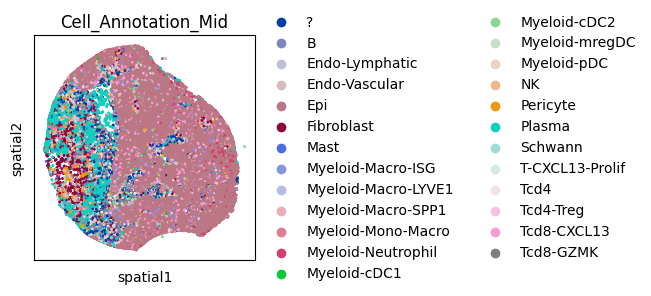

In [6]:
# open the adata from the dysplasia paper as an example and subset 1 core for visualization
adata = sc.read_h5ad('../Xenium_analysis/Xenium_dysplasia/data/dysplasia_manuscript_data/072325_dys_analysis_base.h5ad')
adata_sub = adata[adata.obs['core_id'] == 124]
sq.pl.spatial_scatter(adata_sub, shape = None, color = 'Cell_Annotation_Mid')

In [10]:
create_adata_interface(adata_sub, figsize = (1000,800), html_template=html_template)

Text(value='', description='_data_iframe_1afc7da7d540413c8c01f31c1bda3fb6_obsBtn', layout=Layout(height='1px',…

Text(value='', description='_data_iframe_1afc7da7d540413c8c01f31c1bda3fb6_geneBtn', layout=Layout(height='1px'…

Text(value='', description='_data_iframe_1afc7da7d540413c8c01f31c1bda3fb6_spatialBtn', layout=Layout(height='1…

Text(value='', description='_data_iframe_1afc7da7d540413c8c01f31c1bda3fb6_umapBtn', layout=Layout(height='1px'…

Text(value='', description='_data_iframe_1afc7da7d540413c8c01f31c1bda3fb6_pcaBtn', layout=Layout(height='1px',…

Text(value='', description='_data_iframe_1afc7da7d540413c8c01f31c1bda3fb6_clearObsBtn', layout=Layout(height='…

Text(value='', description='_data_iframe_1afc7da7d540413c8c01f31c1bda3fb6_clearGexBtn', layout=Layout(height='…

Text(value='', description='_data_iframe_1afc7da7d540413c8c01f31c1bda3fb6___save_obs_column__', layout=Layout(…

Button(description='_poll_iframe_1afc7da7d540413c8c01f31c1bda3fb6__obsBtn', layout=Layout(height='1px', visibi…

Button(description='_poll_iframe_1afc7da7d540413c8c01f31c1bda3fb6__geneBtn', layout=Layout(height='1px', visib…

Button(description='_poll_iframe_1afc7da7d540413c8c01f31c1bda3fb6__spatialBtn', layout=Layout(height='1px', vi…

Button(description='_poll_iframe_1afc7da7d540413c8c01f31c1bda3fb6__umapBtn', layout=Layout(height='1px', visib…

Button(description='_poll_iframe_1afc7da7d540413c8c01f31c1bda3fb6__pcaBtn', layout=Layout(height='1px', visibi…

Button(description='_poll_iframe_1afc7da7d540413c8c01f31c1bda3fb6__clearObsBtn', layout=Layout(height='1px', v…

Button(description='_poll_iframe_1afc7da7d540413c8c01f31c1bda3fb6__clearGexBtn', layout=Layout(height='1px', v…

Button(description='_poll_iframe_1afc7da7d540413c8c01f31c1bda3fb6____save_obs_column__', layout=Layout(height=…

Output(layout=Layout(height='0px', visibility='hidden'))

'iframe_1afc7da7d540413c8c01f31c1bda3fb6'

/krummellab/data1/zachsten/software/miniconda3/envs/rapids-sc/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


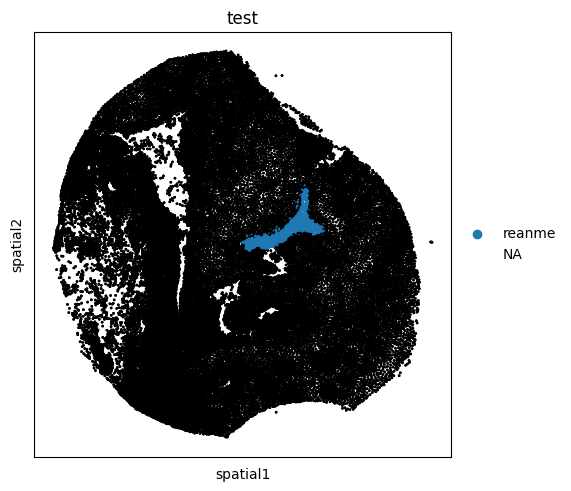

In [12]:
sq.pl.spatial_scatter(adata_sub, shape = None, color = 'test')